# First

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import random
import os

In [2]:
with open('../Data/preprocessed.pkl.zip', 'rb') as f:
    _ = pickle.load(f)
    col_names = pickle.load(f)
    X = pickle.load(f)
    y = pickle.load(f)
    cat_slice = pickle.load(f)
    skewed_slice = pickle.load(f)
    non_skewed_slice = pickle.load(f)
    '''
    X_train = pickle.load(f)
    X_test = pickle.load(f)
    y_train = pickle.load(f)
    y_test = pickle.load(f)
    '''    

In [3]:
col_names, X.shape, y.shape, cat_slice, skewed_slice, non_skewed_slice

(array(['_STATE_1.0', '_STATE_2.0', '_STATE_4.0', ..., 'HTM4',
        'MAXVO2__ALT', 'FC60__ALT'], dtype=object),
 (437514, 1579),
 (437514,),
 slice(0, 1525, None),
 slice(1525, 1573, None),
 slice(1573, 1579, None))

In [4]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #X_cat = X[:, cat_slice]
        #X_skewed = X[:, skewed_slice]
        #X_non_skewed = X[:, non_skewed_slice]
        
        #q_transformer = QuantileTransformer()
        #q_transformer.fit(X_skewed)

        X = sparse.hstack([X[:, cat_slice], QuantileTransformer().fit_transform(X[:, skewed_slice]), X[:, non_skewed_slice]], format='csr')
        
        #Making the matrices dense
        #X_non_skewed_dense = X_non_skewed.toarray()

        #Initializing and fitting the scaler
        #scaler = StandardScaler()
        #scaler.fit(X_non_skewed_dense)

        #Applying the scaling t+
        # eo the dense matrices
        #X_non_skewed_dense = scaler.transform(X_non_skewed_dense)

        #Making the matrices sparse again
        #X_non_skewed = sparse.csr_matrix(X_non_skewed_dense)
        
        #X_non_skewed = sparse.csr_matrix(StandardScaler().fit_transform(X[:, non_skewed_slice].toarray())) 
        X = sparse.hstack([X[:, cat_slice], X[:, skewed_slice], sparse.csr_matrix(StandardScaler().fit_transform(X[:, non_skewed_slice].toarray()))], format='csr')
        
        #del X_non_skewed
        
        #X = sparse.hstack([X_cat, X_skewed, X_non_skewed])
        
        return X

In [5]:
pipeline = Pipeline([('transformation', CustomTransformer()), ('log_regression', LogisticRegression(max_iter=10000))])

In [6]:
%%time

cv_scores = cross_val_score(pipeline, X, y, scoring='roc_auc')

: 

: 

In [5]:
path = '../Data/first_log_model.pkl'
if not os.path.exists(path):
    logistic_regressor = LogisticRegression(max_iter=10000)
    logistic_regressor.fit(X_train, y_train)
    with open(path, 'wb') as f:
        pickle.dump(logistic_regressor, f)
else:
    with open(path, 'rb') as f:
        logistic_regressor = pickle.load(f)

In [6]:
y_pred = logistic_regressor.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     79776
         1.0       0.55      0.16      0.25      7727

    accuracy                           0.91     87503
   macro avg       0.74      0.57      0.60     87503
weighted avg       0.89      0.91      0.89     87503



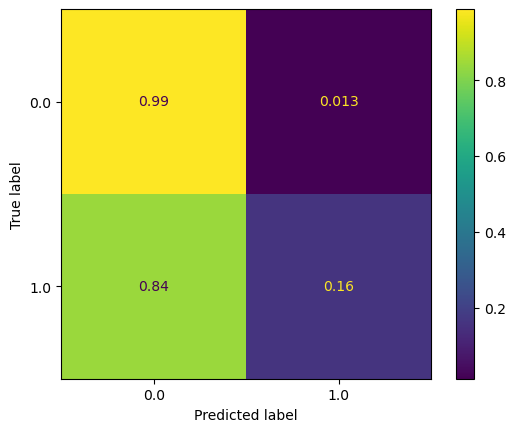

In [7]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()

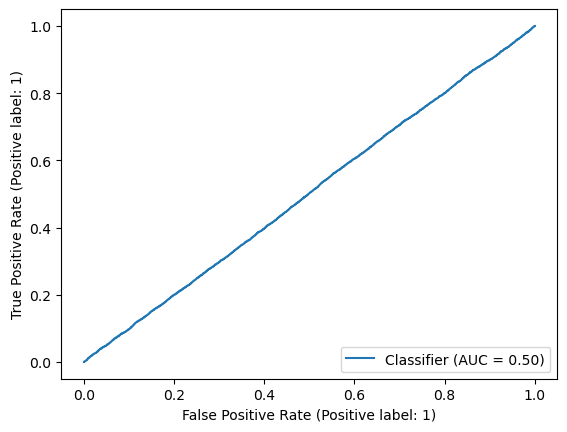

In [49]:
y_pred_rand = [random.uniform(0, 1) for x in y_test]
RocCurveDisplay.from_predictions(y_test, y_pred_rand)
plt.show()

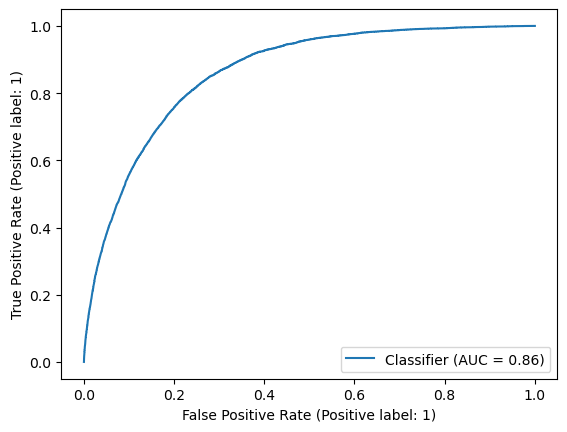

In [44]:
y_pred_prob = logistic_regressor.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_train_train_train_test, y_pred_prob)
plt.show()

In [29]:
def plot_logistic_feature_importance(coefficients, feature_names, number):
    coef_enum = enumerate(coefficients)
    coef_enum_sorted_top = sorted(coef_enum, key=lambda x: abs(x[1]), reverse=True)[:number]
    
    indices = list(list(zip(*coef_enum_sorted_top))[0])
    names = feature_names[indices]
    top_coef = np.array(list(zip(*coef_enum_sorted_top))[1])
    
    neg_pos = np.where(top_coef < 0)[0]
    pos_pos = np.where(top_coef >= 0)[0]
    neg_coef = top_coef[neg_pos]
    pos_coef = top_coef[pos_pos]
    neg_names = names[neg_pos]
    pos_names = names[pos_pos]
    
    _, ax = plt.subplots()
    
    ax.bar(neg_pos, np.abs(neg_coef), color='r', label='negative')
    ax.bar(pos_pos, np.abs(pos_coef), color='b', label='positive')
    ax.set_xticks(range(0, len(names)))
    ax.set_xticklabels(names, rotation=90)
    ax.set_title('Top Features by Absolute Value of Model Coefficient')
    ax.set_ylabel('Feature Coefficient')
    ax.set_xlabel('Features')
    
    ax.legend()
    plt.show()

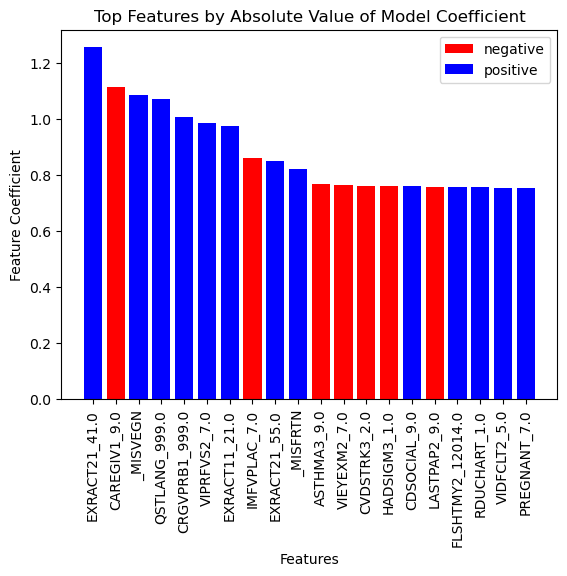

In [30]:
plot_logistic_feature_importance(logistic_regressor.coef_[0], col_names, 20)

In [ ]:
cv_score_list = cross_val_score(logistic_regressor, X_train, y_train, scoring='roc_auc')
print(f'CV scores: {cv_score_list}\nAverage: {cv_score_list.mean()}\nStandard Deviation: {cross_val_score.std()}')

In [63]:
print(f'CV Scores: {cv_score_list}\nAverage: {cv_score_list.mean()}\nStandard Deviation: {cv_score_list.std()}')

CV Scores: [0.86411395 0.86136687 0.86297811 0.86235482 0.86058556]
Average: 0.8622798618083547
Standard Deviation: 0.0012297333907006925


# Second

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import sparse
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
import random
import os

In [2]:
path = '../Data/df_clean_null.pkl'
df = pd.read_pickle(path)

In [3]:
feature_names = ['_RFHLTH', '_HCVU651', '_RFHYPE5', '_RFCHOL', '_ASTHMS1', '_DRDXAR1', '_RACEGR3', '_AGE_G', '_BMI5CAT', '_EDUCAG', '_INCOMG', '_SMOKER3',\
    '_RFDRHV5', '_PACAT1', '_RFSEAT2', '_FLSHOT6', '_PNEUMO2', '_AIDTST3', 'CHCCOPD1', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL', 'DRADVISE']
target_name = ['_MICHD']
weights_name = ['_LLCPWT'] 

In [4]:
df = df[feature_names + target_name + weights_name]
df

,_RFHLTH,_HCVU651,_RFHYPE5,_RFCHOL,_ASTHMS1,_DRDXAR1,_RACEGR3,_AGE_G,_BMI5CAT,_EDUCAG,...,_AIDTST3,CHCCOPD1,ADDEPEV2,CHCKIDNY,DIABETE3,SEX,MARITAL,DRADVISE,_MICHD,_LLCPWT
0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,5.0,4.0,2.0,...,1.0,1.0,1.0,2.0,3.0,2.0,1.0,NaN,2.0,341.384853
1,1.0,2.0,1.0,1.0,3.0,2.0,1.0,4.0,3.0,4.0,...,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,108.060903
2,2.0,9.0,1.0,2.0,3.0,1.0,1.0,6.0,2.0,2.0,...,NaN,2.0,2.0,2.0,3.0,2.0,2.0,NaN,NaN,255.264797
3,2.0,1.0,2.0,2.0,3.0,1.0,1.0,5.0,3.0,2.0,...,9.0,2.0,1.0,2.0,3.0,2.0,1.0,2.0,2.0,341.384853
4,2.0,1.0,1.0,1.0,3.0,1.0,1.0,5.0,2.0,3.0,...,1.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,258.682223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,2.0,9.0,2.0,2.0,3.0,1.0,5.0,6.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,2.0,531.980410
441452,1.0,1.0,1.0,1.0,3.0,2.0,5.0,2.0,3.0,3.0,...,1.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,746.416599
441453,2.0,9.0,2.0,2.0,3.0,2.0,5.0,6.0,4.0,2.0,...,NaN,2.0,2.0,2.0,3.0,2.0,1.0,NaN,2.0,207.663634
441454,1.0,1.0,2.0,1.0,3.0,2.0,5.0,4.0,2.0,3.0,...,2.0,2.0,2.0,2.0,3.0,1.0,5.0,1.0,2.0,515.758894


In [5]:
for column in ['_RFHYPE5', '_RFCHOL', '_RFDRHV5']:
    df[column] = df[column].apply(lambda x: 1.0 if x == 2.0 else 2.0 if x == 1.0 else x)

In [6]:
for column in ['_FLSHOT6', '_PNEUMO2']:
    df[column] = df[column].cat.add_categories([65.0])
    df[column] = df[column].fillna(65.0)

In [7]:
df['DIABETE3'] = df['DIABETE3'].map({1.0:1.0, 2.0:1.0, 3.0:2.0, 4.0:2.0, 7.0:7.0, 9.0:9.0}).astype('category')

In [8]:
df['_MICHD'] = df['_MICHD'].apply(lambda x: 0.0 if x == 2 else x)

In [9]:
def imputer(dataframe, category_value_tofill=None, columns_drop=None, columns_mode=None, columns_median=None):
    '''Imputes missing values to the input dataframe.
    
       Parameters
       ----------
       dataframe: Pandas dataframe
           dataframe with which to impute missing values.
       
       category_value_tofill: int, float, or string
           Value to used to fill missing values in categorical features.
       
       columns_drop: list-like
           List of columns to drop.
       
       columns_mode: list-like
           List of numeric columns to impute with the mode.
           
       columns_median: list-like
           List of numeric columns to impute with the mean.
    '''
    #Fill null values in categorical features with value_null
    if category_value_tofill != None:
        for column in dataframe.select_dtypes(include='category').columns:
            if any(dataframe[column].isnull()):
                dataframe[column] = dataframe[column].cat.add_categories([category_value_tofill])
                dataframe[column] = dataframe[column].fillna(value=category_value_tofill)
            
    #Droping columns, imputing with mode, and imputing with median.
    if columns_drop != None:
        dataframe = dataframe.drop(columns=columns_drop)
    if columns_mode != None:
        dataframe = dataframe.fillna(dataframe[columns_mode].mode().iloc[0, :])
    if columns_median != None:
        dataframe = dataframe.fillna(dataframe[columns_median].median())
    
    return dataframe

In [10]:
df = imputer(df, 999.0)

In [11]:
trans_list = ['Good_Health', 'Health_Insurance', 'Hypertension', 'High_Cholesterol', 'Asthma_Status', 'Arthritis', 'Race', 'Age_Cat', 'BMI_Cat', 'Education_Level', 'Income_Level', \
    'Smoker_Status', 'Heavy_Drinker', 'Physical_Activity', 'Seatbelt', 'Flu_Shot', 'Pneumonia_Vaccine', 'HIV', 'Bronchitis', 'Depression', 'Kidney_Disease', 'Diabetes', 'SEX', \
        'Marital Status', 'Sodium', 'Heart_Disease', 'Sample_Weights']

In [12]:
trans_dict = dict(zip(feature_names + target_name + weights_name, trans_list))
trans_dict

{'_RFHLTH': 'Good_Health',
 '_HCVU651': 'Health_Insurance',
 '_RFHYPE5': 'Hypertension',
 '_RFCHOL': 'High_Cholesterol',
 '_ASTHMS1': 'Asthma_Status',
 '_DRDXAR1': 'Arthritis',
 '_RACEGR3': 'Race',
 '_AGE_G': 'Age_Cat',
 '_BMI5CAT': 'BMI_Cat',
 '_EDUCAG': 'Education_Level',
 '_INCOMG': 'Income_Level',
 '_SMOKER3': 'Smoker_Status',
 '_RFDRHV5': 'Heavy_Drinker',
 '_PACAT1': 'Physical_Activity',
 '_RFSEAT2': 'Seatbelt',
 '_FLSHOT6': 'Flu_Shot',
 '_PNEUMO2': 'Pneumonia_Vaccine',
 '_AIDTST3': 'HIV',
 'CHCCOPD1': 'Bronchitis',
 'ADDEPEV2': 'Depression',
 'CHCKIDNY': 'Kidney_Disease',
 'DIABETE3': 'Diabetes',
 'SEX': 'SEX',
 'MARITAL': 'Marital Status',
 'DRADVISE': 'Sodium',
 '_MICHD': 'Heart_Disease',
 '_LLCPWT': 'Sample_Weights'}

In [13]:
df = df.rename(columns=trans_dict)
df

,Good_Health,Health_Insurance,Hypertension,High_Cholesterol,Asthma_Status,Arthritis,Race,Age_Cat,BMI_Cat,Education_Level,...,HIV,Bronchitis,Depression,Kidney_Disease,Diabetes,SEX,Marital Status,Sodium,Heart_Disease,Sample_Weights
0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,4.0,2.0,...,1.0,1.0,1.0,2.0,2.0,2.0,1.0,999.0,0.0,341.384853
1,1.0,2.0,2.0,2.0,3.0,2.0,1.0,4.0,3.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,108.060903
2,2.0,9.0,2.0,1.0,3.0,1.0,1.0,6.0,2.0,2.0,...,999.0,2.0,2.0,2.0,2.0,2.0,2.0,999.0,999.0,255.264797
3,2.0,1.0,1.0,1.0,3.0,1.0,1.0,5.0,3.0,2.0,...,9.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,0.0,341.384853
4,2.0,1.0,2.0,2.0,3.0,1.0,1.0,5.0,2.0,3.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,258.682223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,2.0,9.0,1.0,1.0,3.0,1.0,5.0,6.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,0.0,531.980410
441452,1.0,1.0,2.0,2.0,3.0,2.0,5.0,2.0,3.0,3.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,746.416599
441453,2.0,9.0,1.0,1.0,3.0,2.0,5.0,6.0,4.0,2.0,...,999.0,2.0,2.0,2.0,2.0,2.0,1.0,999.0,0.0,207.663634
441454,1.0,1.0,1.0,2.0,3.0,2.0,5.0,4.0,2.0,3.0,...,2.0,2.0,2.0,2.0,2.0,1.0,5.0,1.0,0.0,515.758894


In [14]:
df = df.drop(df[df[trans_dict[target_name[0]]] == 999.0].index)

In [22]:
cols_to_one_hot = [column for column in df.select_dtypes(include='category').columns if column not in ['Heart_Disease']]

column_trans = ColumnTransformer([('categorical', OneHotEncoder(sparse=False), cols_to_one_hot)], remainder='passthrough')
column_trans.fit(df)
column_names_trans = np.concatenate([column_trans.named_transformers_['categorical'].get_feature_names_out(), np.array([trans_dict[target_name[0]], trans_dict[weights_name[0]]])])

In [23]:
df = pd.DataFrame(column_trans.transform(df), columns=column_names_trans)
df

,Good_Health_1.0,Good_Health_2.0,Good_Health_9.0,Health_Insurance_1.0,Health_Insurance_2.0,Health_Insurance_9.0,Hypertension_1.0,Hypertension_2.0,Hypertension_9.0,High_Cholesterol_1.0,...,Marital Status_5.0,Marital Status_6.0,Marital Status_9.0,Sodium_1.0,Sodium_2.0,Sodium_7.0,Sodium_9.0,Sodium_999.0,Heart_Disease,Sample_Weights
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,341.384853
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,108.060903
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,341.384853
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,258.682223
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,256.518591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437509,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,531.980410
437510,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,746.416599
437511,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,207.663634
437512,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,515.758894


## Training

In [26]:
y = df[trans_dict[target_name[0]]]
w = df[trans_dict[weights_name[0]]]
X = df.drop(columns=[y.name, w.name])

In [27]:
y[y==1.0].shape[0] / y.shape[0]

0.08830117436242041

In [30]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, stratify=y)

In [31]:
y_train[y_train==1.0].shape[0] / y_train.shape[0], y_test[y_test==1.0].shape[0] / y_test.shape[0]

(0.08830008199742294, 0.08830554380992651)

In [33]:
log_regressor = LogisticRegression(max_iter=500)
log_regressor.fit(X_train, y_train, sample_weight=w_train)

LogisticRegression(max_iter=10000)

In [36]:
y_pred_train = log_regressor.predict(X_train)

In [37]:
y_pred = log_regressor.predict(X_test)

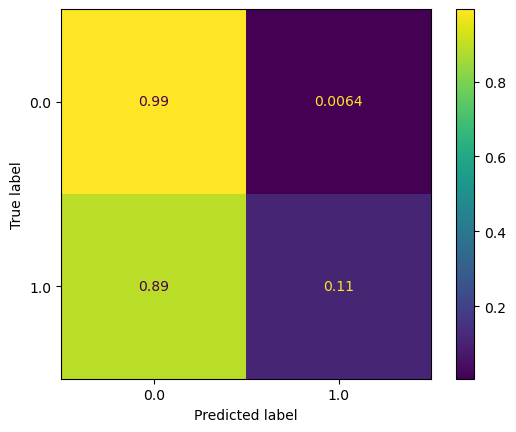

In [45]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, sample_weight=w_train, normalize='true')
plt.show()

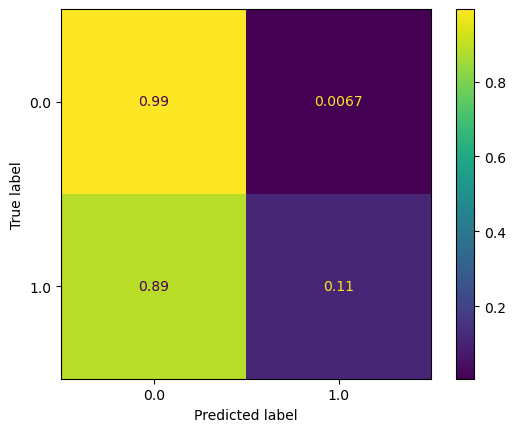

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, sample_weight=w_test, normalize='true')
plt.show()

In [38]:
print(classification_report(y_train, y_pred_train, sample_weight=w_train))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97 186467071.23789763
         1.0       0.54      0.11      0.18 12744404.934554698

    accuracy                           0.94 199211476.17245233
   macro avg       0.74      0.55      0.57 199211476.17245233
weighted avg       0.92      0.94      0.92 199211476.17245233



In [39]:
print(classification_report(y_test, y_pred, sample_weight=w_test))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97 46912828.24631925
         1.0       0.54      0.11      0.18 3264496.451715473

    accuracy                           0.94 50177324.69803472
   macro avg       0.74      0.55      0.58 50177324.69803472
weighted avg       0.92      0.94      0.92 50177324.69803472



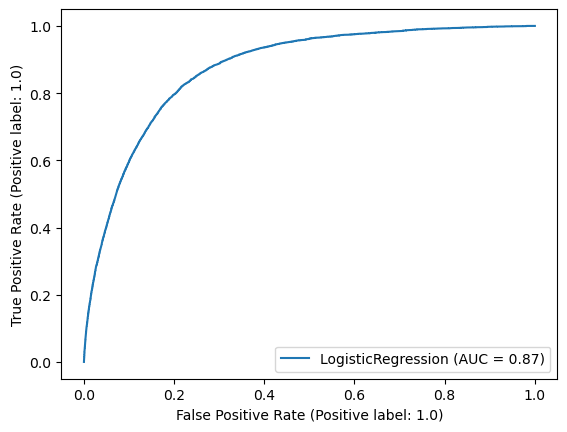

In [48]:
RocCurveDisplay.from_estimator(log_regressor, X_train, y_train, sample_weight=w_train)
plt.show()

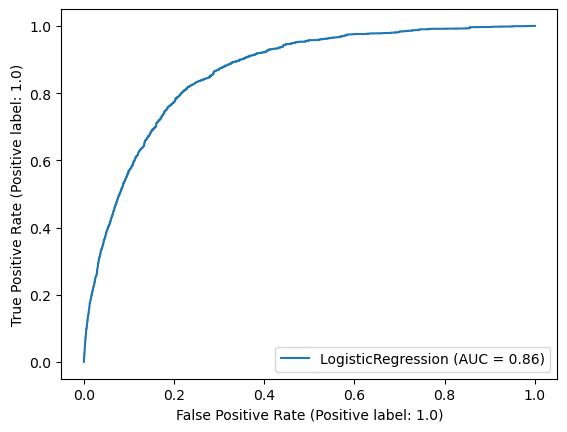

In [49]:
RocCurveDisplay.from_estimator(log_regressor, X_test, y_test, sample_weight=w_test)
plt.show()

In [58]:
def plot_logistic_feature_importance(coefficients, feature_names, number):
    coef_enum = enumerate(coefficients)
    coef_enum_sorted_top = sorted(coef_enum, key=lambda x: abs(x[1]), reverse=True)[:number]
    
    indices = list(list(zip(*coef_enum_sorted_top))[0])
    names = feature_names[indices]
    top_coef = np.array(list(zip(*coef_enum_sorted_top))[1])
    
    neg_pos = np.where(top_coef < 0)[0]
    pos_pos = np.where(top_coef >= 0)[0]
    neg_coef = top_coef[neg_pos]
    pos_coef = top_coef[pos_pos]
    neg_names = names[neg_pos]
    pos_names = names[pos_pos]
    
    _, ax = plt.subplots()
    
    ax.bar(neg_pos, np.abs(neg_coef), color='r', label='Negative')
    ax.bar(pos_pos, np.abs(pos_coef), color='b', label='Positive')
    ax.set_xticks(range(0, len(names)))
    ax.set_xticklabels(names, rotation=90)
    ax.set_title('Top Features by Absolute Value of Model Coefficient')
    ax.set_ylabel('Feature Coefficient')
    ax.set_xlabel('Features')
    
    ax.legend()
    plt.show()

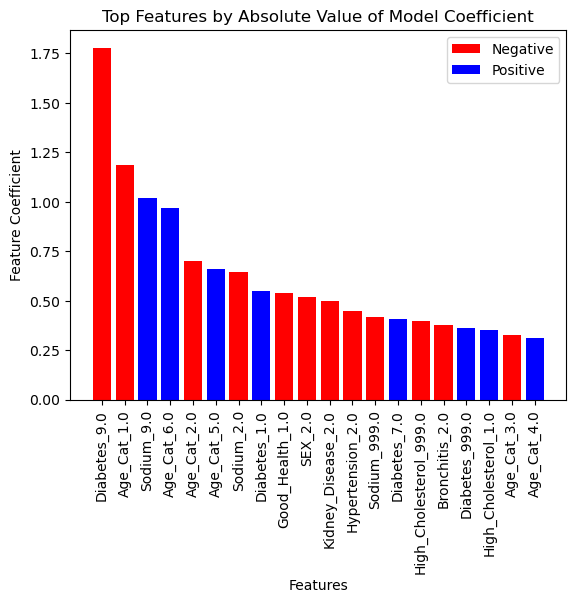

In [59]:
plot_logistic_feature_importance(log_regressor.coef_[0], log_regressor.feature_names_in_, 20)

In [79]:
fpr, tpr, threshold = roc_curve(y_test, log_regressor.predict_proba(X_test)[:, 1], sample_weight=w_test)

In [101]:
indices = np.where((fpr > 0.1999) & (fpr < 0.2001))
print(fpr[indices], '\n')
print(threshold[indices])

[0.19991108 0.19991347 0.19991623 0.19991784 0.19991784 0.19992216
 0.19993111 0.19994143 0.19994217 0.19994507 0.19994553 0.19996309
 0.19996438 0.19997019 0.20003856 0.20005948 0.20006687 0.20006761] 

[0.07589201 0.0758918  0.07589066 0.07588502 0.07588498 0.0758804
 0.0758781  0.07587753 0.07587404 0.07587366 0.0758642  0.0758621
 0.0758567  0.07585289 0.07585206 0.07584721 0.07584302 0.07583964]


In [102]:
y_pred_new = (log_regressor.predict_proba(X_test)[:,1]>=0.076).astype(int)

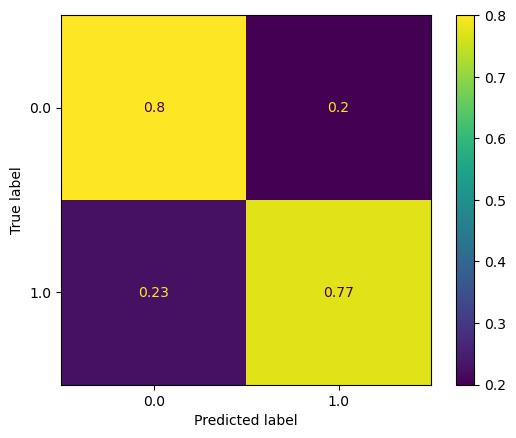

In [109]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_new, sample_weight=w_test, normalize='true')
plt.show()

In [106]:
print(classification_report(y_test, y_pred_new, sample_weight=w_test))

              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88 46912828.24631925
         1.0       0.21      0.77      0.33 3264496.451715473

    accuracy                           0.80 50177324.69803472
   macro avg       0.60      0.79      0.61 50177324.69803472
weighted avg       0.93      0.80      0.85 50177324.69803472



In [118]:
cv_scores = cross_val_score(log_regressor, X, y, fit_params={'sample_weight':w}, scoring='roc_auc')

In [127]:
cv_scores, cv_scores.mean(), cv_scores.std()

(array([0.83903345, 0.84718019, 0.84505138, 0.8455445 , 0.84173371]),
 0.8437086455341619,
 0.0029319869983208415)

In [122]:
log_regressor_bal = LogisticRegression(class_weight='balanced', max_iter=500)
log_regressor_bal.fit(X_train, y_train, sample_weight=w_train)

LogisticRegression(class_weight='balanced', max_iter=500)

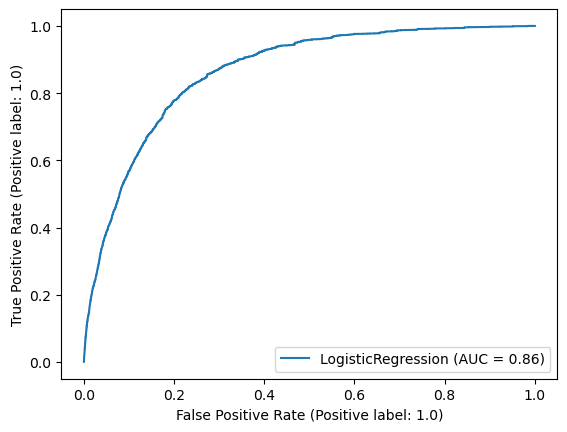

In [123]:
RocCurveDisplay.from_estimator(log_regressor_bal, X_test, y_test, sample_weight=w_test)
plt.show()

In [124]:
cv_scores_bal = cross_val_score(log_regressor_bal, X, y, fit_params=dict(sample_weight=w), scoring='roc_auc')

In [128]:
cv_scores_bal, cv_scores_bal.mean(), cv_scores_bal.std()

(array([0.83875716, 0.84710798, 0.84497008, 0.84512636, 0.84180897]),
 0.8435541092338299,
 0.002938134893023775)

In [36]:
from imblearn.over_sampling import RandomOverSampler

In [47]:
sampler = RandomOverSampler()
X_res, y_res = sampler.fit_resample(X, y)

In [48]:
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res)

In [50]:
y_res_train[y_res_train == 1.0].shape[0] / y_res_train.shape[0]

0.4993907952420189

In [51]:
y_res_test[y_res_test == 1.0].shape[0] / y_res_test.shape[0]

0.5018276081648206

In [52]:
log_regressor.fit(X_res_train, y_res_train)

LogisticRegression(max_iter=10000)

/home/hiram/Springboard/.conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


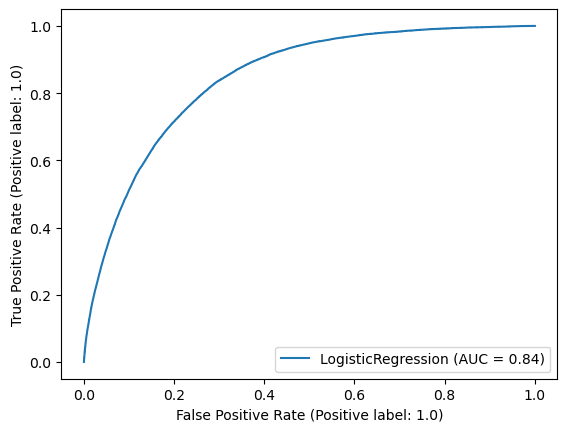

In [53]:
plot_roc_curve(log_regressor, X_res_test, y_res_test)

In [34]:
y_res_train_pred = log_regressor.predict(X_train)

In [35]:
print(classification_report(y_train, y_res_train_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95    319105
         1.0       0.53      0.11      0.18     30906

    accuracy                           0.91    350011
   macro avg       0.73      0.55      0.57    350011
weighted avg       0.89      0.91      0.89    350011

